In [4]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
import cv2
from sklearn.model_selection import train_test_split
import pickle
import os
import pandas as pd
import random
from PIL import Image

#** Download these first
#!pip install keras==2.3.1
#!pip install tensorflow==2.0.0

Using TensorFlow backend.


## Remember to download keras and tensorflow with the below version

In [22]:
#pip install keras==2.3.1
#pip install tensorflow==2.0.0

## Parameters

In [5]:
path = "GTSRB_Final_Training_Images/GTSRB/Final_Training/Images" #path to folder w/ all the class
path_test = "GTSRB_Final_Test_Images/GTSRB/Final_Test/Images" #path for testing data unlabel w/ class
#labelFile
batch_size = 50
steps_per_epoch = 2000
epoch = 30
image_dim = (32,32,1)
#testing ratio
validation_ratio = 0.2 #80:20% for validation test for adjust hyperparameter

## Data count for each class

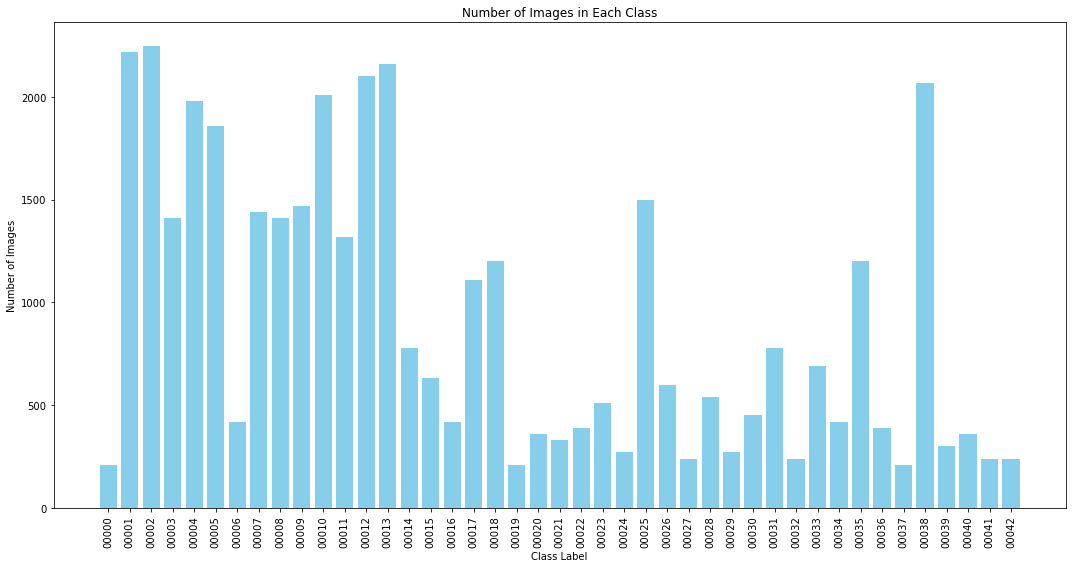

In [6]:
class_counts = {}
images = []  
labels = []  

list_dir = os.listdir(path)

for class_folder in list_dir:
    class_path = os.path.join(path, class_folder)
    if os.path.isdir(class_path):
        
        csv_file = f"GT-{class_folder}.csv"
        csv_path = os.path.join(class_path, csv_file)
        
        annotations = pd.read_csv(csv_path, delimiter=';')
        
        # update class counts
        class_counts[class_folder] = len(annotations)
        
        for index, row in annotations.iterrows():
            img_path = os.path.join(class_path, row['Filename'])
            
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            
            # ******Crop the image based on the ROI******
            roi_x1, roi_y1, roi_x2, roi_y2 = row['Roi.X1'], row['Roi.Y1'], row['Roi.X2'], row['Roi.Y2']
            img_cropped = img[roi_y1:roi_y2, roi_x1:roi_x2]
            
            # Equalize the histogram for better contrast
            img_eq = cv2.equalizeHist(img_cropped)
            
            # Resize image
            img_resized = cv2.resize(img_eq, (32, 32))
            
            # Normalize
            img_normalized = img_resized / 255.0
            
            images.append(img_normalized)
            labels.append(int(class_folder))


images = np.array(images)
labels = np.array(labels)

# reshape images to have a channel dimension
images = images.reshape(images.shape[0], 32, 32, 1)

# Splitting training and validation sets
validation_ratio = 0.2
X_train, X_validation, Y_train, Y_validation = train_test_split(images, labels, test_size=validation_ratio, random_state=42)

class_names = list(class_counts.keys())
counts = list(class_counts.values())

plt.figure(figsize=(15, 8))
plt.bar(class_names, counts, color='skyblue')
plt.xlabel('Class Label')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## How the first image look after preprocess

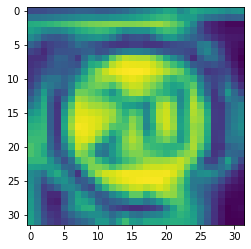

In [7]:
plt.imshow(images[0])
plt.show()

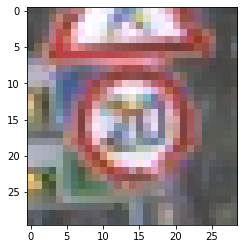

In [35]:
#The look without preprocess

image = Image.open(path + '/00000/00000_00000.ppm')
plt.imshow(image)
plt.show()

In [32]:
len(images)

39209

In [8]:
Y_train_encoded = to_categorical(Y_train)
Y_validation_encoded = to_categorical(Y_validation)

#CNN Model
def create_cnn_model():
    model = Sequential()

    # Layer 1: Convolutional Layer
    model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=image_dim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))

    # Layer 2: Convolutional Layer
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))

    # Flattening the matrix into vector form
    model.add(Flatten())

    # Layer 3: Fully Connected Layer
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.5))

    # Layer 4: Output Layer
    # Number of neurons = number of classes in the dataset
    model.add(Dense(len(class_names), activation='softmax'))

    return model


model = create_cnn_model()
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)             

## Determine the best number of epochs for training

Train on 31367 samples, validate on 7842 samples
Epoch 1/30
31367/31367 [==============================] - 31s 978us/step - loss: 1.0303 - accuracy: 0.7114 - val_loss: 0.1446 - val_accuracy: 0.9625
Epoch 2/30
31367/31367 [==============================] - 43s 1ms/step - loss: 0.2275 - accuracy: 0.9317 - val_loss: 0.0663 - val_accuracy: 0.9844
Epoch 3/30
31367/31367 [==============================] - 42s 1ms/step - loss: 0.1551 - accuracy: 0.9518 - val_loss: 0.0505 - val_accuracy: 0.9876
Epoch 4/30
31367/31367 [==============================] - 43s 1ms/step - loss: 0.1133 - accuracy: 0.9651 - val_loss: 0.0419 - val_accuracy: 0.9903
Epoch 5/30
31367/31367 [==============================] - 42s 1ms/step - loss: 0.0907 - accuracy: 0.9704 - val_loss: 0.0375 - val_accuracy: 0.9915
Epoch 6/30
31367/31367 [==============================] - 42s 1ms/step - loss: 0.0832 - accuracy: 0.9742 - val_loss: 0.0348 - val_accuracy: 0.9927
Epoch 7/30
31367/31367 [==============================] - 42s 1ms/s

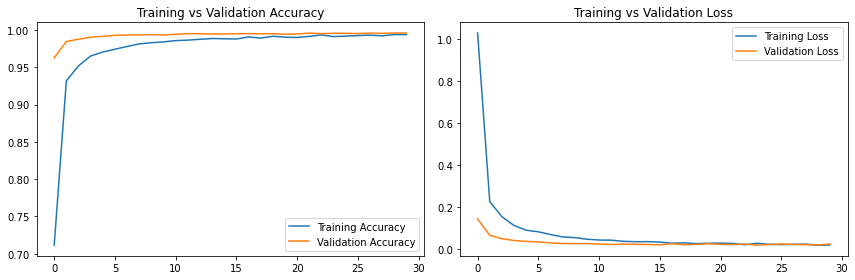

In [9]:
# Train  Model
history = model.fit(X_train, Y_train_encoded, batch_size=batch_size, epochs=epoch, 
                    validation_data=(X_validation, Y_validation_encoded), shuffle=True)

# Visualize Training & Validation Accuracy/Loss
plt.figure(figsize=(12, 4))

# Plotting the training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')

# Plotting the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training vs Validation Loss')

plt.tight_layout()
plt.show()


### Observation

After the 12th epoch, the validation accuracy starts to plateau or even decrease slightly, while the training accuracy continues to improve. This divergence between training and validation accuracy is a classic indication of overfitting: the model is becoming better and better on the training data, but its performance on unseen validation data isn't improving at the same rate or might even be deteriorating.

By choosing to stop training around the 12th epoch, we can have a model that generalizes well to new, unseen data, rather than a model that is overly specialized to the training set. Furthermore, this early stopping can also save computational resources and time, as we would not be training for additional epochs that don't contribute to model improvement on validation data.

## Re-Train with epoch=12 (Model 2)

In [10]:
model2 = create_cnn_model()
model2.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model2.fit(X_train, Y_train_encoded, batch_size=batch_size, epochs=12, 
                    validation_data=(X_validation, Y_validation_encoded), shuffle=True)

Train on 31367 samples, validate on 7842 samples
Epoch 1/12
31367/31367 [==============================] - 26s 813us/step - loss: 0.9100 - accuracy: 0.7487 - val_loss: 0.1401 - val_accuracy: 0.9644
Epoch 2/12
31367/31367 [==============================] - 41s 1ms/step - loss: 0.2097 - accuracy: 0.9361 - val_loss: 0.0720 - val_accuracy: 0.9836
Epoch 3/12
31367/31367 [==============================] - 40s 1ms/step - loss: 0.1391 - accuracy: 0.9572 - val_loss: 0.0504 - val_accuracy: 0.9874
Epoch 4/12
31367/31367 [==============================] - 39s 1ms/step - loss: 0.1050 - accuracy: 0.9662 - val_loss: 0.0408 - val_accuracy: 0.9893
Epoch 5/12
31367/31367 [==============================] - 40s 1ms/step - loss: 0.0887 - accuracy: 0.9718 - val_loss: 0.0340 - val_accuracy: 0.9925
Epoch 6/12
31367/31367 [==============================] - 41s 1ms/step - loss: 0.0726 - accuracy: 0.9769 - val_loss: 0.0340 - val_accuracy: 0.9923
Epoch 7/12
31367/31367 [==============================] - 45s 1ms/s

## Test with different batch size

Batch Size: 1, Accuracy: 0.9996
Batch Size: 10, Accuracy: 0.9996
Batch Size: 32, Accuracy: 0.9996
Batch Size: 64, Accuracy: 0.9996
Batch Size: 128, Accuracy: 0.9996
Batch Size: 256, Accuracy: 0.9996
Batch Size: 512, Accuracy: 0.9996


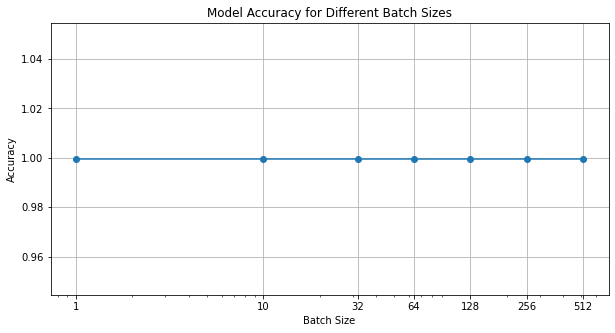

In [11]:
# list of batch sizes
batch_sizes = [1, 10, 32, 64, 128, 256, 512]


accuracy_per_batch_size = {}

for batch_size in batch_sizes:
    loss, accuracy = model2.evaluate(X_train, Y_train_encoded, batch_size=batch_size, verbose=0)
    
    # Store the accuracy in the dictionary
    accuracy_per_batch_size[batch_size] = accuracy
    print(f"Batch Size: {batch_size}, Accuracy: {accuracy:.4f}")

# Optionally, you can also plot the accuracies for visual comparison
plt.figure(figsize=(10, 5))
plt.plot(list(accuracy_per_batch_size.keys()), list(accuracy_per_batch_size.values()), marker='o')
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.title('Model Accuracy for Different Batch Sizes')
plt.xscale('log')  # Since batch sizes are typically in powers of 2, a log scale may be appropriate
plt.xticks(list(accuracy_per_batch_size.keys()), list(accuracy_per_batch_size.keys()))  # Ensure all batch sizes appear as ticks
plt.grid(True)
plt.show()


# Model Prediction 

In [12]:
def predict_image_class(model, image_path):
    # Load the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Preprocess the image
    img = cv2.equalizeHist(img)  
    img = cv2.resize(img, (32, 32))  
    img = img / 255.0  
    img = img.reshape(1, 32, 32, 1)  

    # Predict the class
    predictions = model.predict(img)
    predicted_class = np.argmax(predictions)
    confidence_percentage = predictions[0][predicted_class] * 100

    return predicted_class, confidence_percentage

def get_class(classs):
    if classs == 0: return 'Speed Limit 20 km/h'
    elif classs == 1: return 'Speed Limit 30 km/h'
    elif classs == 2: return 'Speed Limit 50 km/h'
    elif classs == 3: return 'Speed Limit 60 km/h'
    elif classs == 4: return 'Speed Limit 70 km/h'
    elif classs == 5: return 'Speed Limit 80 km/h'
    elif classs == 6: return 'End of Speed Limit 80 km/h'
    elif classs == 7: return 'Speed Limit 100 km/h'
    elif classs == 8: return 'Speed Limit 120 km/h'
    elif classs == 9: return 'No Passing ?'
    elif classs == 10: return 'No passing for vehicle over 3.5 tons'
    else:
        return f"Class {classs}"

In [13]:
model = model
image_path = path_test+"/00014.ppm"

classs, precentage = predict_image_class(model, image_path)

print(f"Class: {get_class(classs)} | Prediction Accuracy: {precentage}")

Class: Speed Limit 70 km/h | Prediction Accuracy: 90.82181453704834


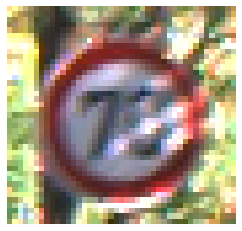

In [14]:
image = Image.open(image_path)

# Display the image using matplotlib
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()

# Save Model

In [36]:
model2.save('trained_model.h5')

# Evaluate Model (Accuracy)

### Get classID for testing data

In [24]:
path_to_test_csv = 'evaluation/GTSRB_Test_GT.csv'

with open(path_to_test_csv) as f:
    lines = f.readlines()
lines = lines[1:]

In [25]:
# Function to preprocess the image based on the ROI
def preprocess_image(image_path, roi):
    # Load the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Crop the image based on the ROI
    img_cropped = img[roi[1]:roi[3], roi[0]:roi[2]]
    
    # Preprocess the image
    img_eq = cv2.equalizeHist(img_cropped)  
    img_resized = cv2.resize(img_eq, (32, 32))  
    img_normalized = img_resized / 255.0  
    img_final = img_normalized.reshape(1, 32, 32, 1)  
    
    return img_final

# Function to extract ROI and class_id
def extract_info_from_csv_line(line):
    parts = line.strip().split(';')
    class_id = int(parts[-1])
    roi = [int(parts[i]) for i in range(3, 7)]  #Extracting Roi
    return roi, class_id

def predict_image_class(model, img):
    predictions = model.predict(img)
    predicted_class = np.argmax(predictions)
    return predicted_class

# The MODEL2 with epoch=12

In [27]:
correct_predictions_per_class = {}
total_instances_per_class = {}

for line in lines:
    roi, actual_class_id = extract_info_from_csv_line(line)
    image_filename = line.split(';')[0]
    image_path = os.path.join(path_test, image_filename)
    img = preprocess_image(image_path, roi)
    predicted_class_id = predict_image_class(model2, img)
    
    # Update total instances for the actual class
    total_instances_per_class[actual_class_id] = total_instances_per_class.get(actual_class_id, 0) + 1
    
    #update correct predictions for the actual class
    if predicted_class_id == actual_class_id:
        correct_predictions_per_class[actual_class_id] = correct_predictions_per_class.get(actual_class_id, 0) + 1

# Calculate accuracy
total_correct_predictions = sum(correct_predictions_per_class.values())
total_images = sum(total_instances_per_class.values())
overall_accuracy = total_correct_predictions / total_images
print(f"Overall Accuracy: {overall_accuracy * 100:.2f}%")

# Calculate class accuracyc
for class_id in range(len(total_instances_per_class)):
    correct_count = correct_predictions_per_class.get(class_id, 0)
    total_count = total_instances_per_class[class_id]
    accuracy = correct_count / total_count if total_count else 0
    print(f"Accuracy for class {class_id}: {accuracy * 100:.2f}%")

Overall Accuracy: 97.77%
Accuracy for class 0: 98.33%
Accuracy for class 1: 98.89%
Accuracy for class 2: 99.47%
Accuracy for class 3: 97.56%
Accuracy for class 4: 97.73%
Accuracy for class 5: 99.05%
Accuracy for class 6: 80.00%
Accuracy for class 7: 97.78%
Accuracy for class 8: 97.33%
Accuracy for class 9: 100.00%
Accuracy for class 10: 99.39%
Accuracy for class 11: 99.29%
Accuracy for class 12: 98.41%
Accuracy for class 13: 99.72%
Accuracy for class 14: 99.63%
Accuracy for class 15: 100.00%
Accuracy for class 16: 99.33%
Accuracy for class 17: 100.00%
Accuracy for class 18: 91.03%
Accuracy for class 19: 98.33%
Accuracy for class 20: 95.56%
Accuracy for class 21: 95.56%
Accuracy for class 22: 98.33%
Accuracy for class 23: 100.00%
Accuracy for class 24: 96.67%
Accuracy for class 25: 97.71%
Accuracy for class 26: 81.67%
Accuracy for class 27: 98.33%
Accuracy for class 28: 96.00%
Accuracy for class 29: 98.89%
Accuracy for class 30: 77.33%
Accuracy for class 31: 99.26%
Accuracy for class 32

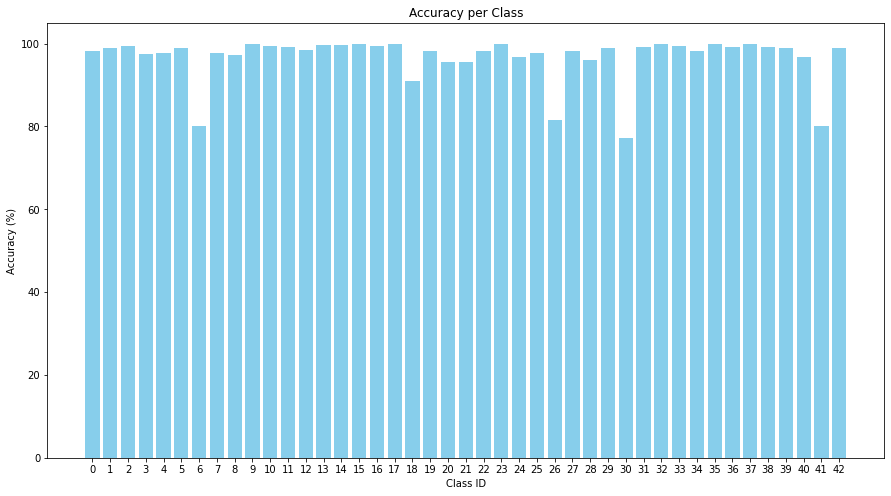

In [31]:
class_accuracies = []
for class_id in range(len(total_instances_per_class)):
    correct_count = correct_predictions_per_class.get(class_id, 0)
    total_count = total_instances_per_class[class_id]
    accuracy = correct_count / total_count if total_count else 0
    class_accuracies.append(accuracy)

plt.figure(figsize=(15, 8))
plt.bar(range(len(class_accuracies)), [acc * 100 for acc in class_accuracies], color='skyblue')
plt.xlabel('Class ID')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy per Class')
plt.xticks(range(len(class_accuracies)), range(len(class_accuracies)))
plt.show()
